In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale

import os
import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from networks import *
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torchvision
from networks import * 
from torch import optim

from torch.utils.tensorboard import SummaryWriter

# Set hyperparams

In [2]:
epochs = 10
lr = 0.001
batch_size = 32

#Creating a tensorboard instance
writer = SummaryWriter('runs/experiment_tensorboard')
# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

# Fix data

Loaded 7999 images
torch.Size([3, 256, 256])
Your classes are:  ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
9
Label:  0 Black Sea Sprat


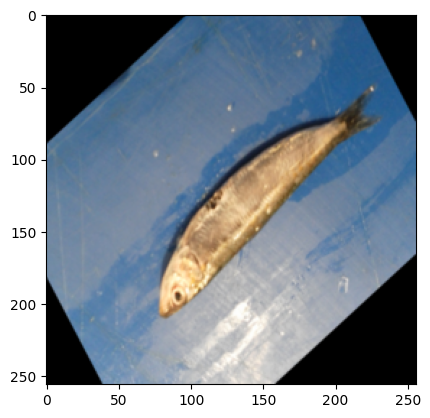

In [3]:
classes = {
  0: "Black Sea Sprat",
  1: "Gilt-Head Bream",
  1: "Hourse Mackerel",
  2: "Red Sea Bream",
  3: "Shrimp"
}

def load_data(width, height, color):
    if (color): transform = Compose([ Resize((width, height)), ToTensor(), transforms.Normalize([0.,], [1.])]) #Grayscale(1), 
    else: transform = Compose([Grayscale(1), Resize((width, height)), ToTensor(), transforms.Normalize([0.,], [1.])])
    dataset = ImageFolder('C:/Users/ingvilrh/OneDrive - NTNU/Masteroppgave23/full_fishdata', transform=transform)
    print('Loaded', len(dataset), 'images')
    return dataset

def split_dataset(dataset, train_part):
    train_size = int(train_part * len(dataset))
    val_size = test_size = (len(dataset) - train_size) // 2
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

def check_classes(dataset):
    print("Your classes are: ", dataset.classes)
    return len(dataset.classes)

def get_datasize(dataset, idx):
    image, label = dataset[idx]
    return image.size()

def show_image(dataset, idx):
    image, label = dataset[idx]
    plt.figure(1)
    plt.imshow(image.permute(1,2,0), cmap='gray')
    print("Label: ", label, classes[label])

def generate_class_dict(data):
    class_lst = data.classes
    keys = range(0, len(class_lst))
    class_dict = {key: None for key in keys}
    for i in range(len(class_lst)):
        class_dict[i] = class_lst[i]
    return class_dict

    

data = load_data(256,256,1)

print(get_datasize(data, 0))

num_classes = check_classes(data)
 
print(num_classes)

classes = generate_class_dict(data)

show_image(data, 0)



# Make dataloaders

In [4]:
def make_dataloaders(train_dataset, val_dataset, test_dataset):
    train_dataloader = DataLoader(train_dataset, batch_size)
    val_dataloader = DataLoader(train_dataset, batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
    return train_dataloader, val_dataloader, test_dataloader

train_data, val_data, test_data = split_dataset(data, 0.7)
train_loader, val_loader, test_loader = make_dataloaders(train_data, val_data, test_data)
print("Your dataset has a length of:", len(data))
print("Your training set has a length of:", len(train_data))
print("Your test set has a length of:", len(test_data))
print("Your val set has a length of:", len(val_data))



Your dataset has a length of: 7999
Your training set has a length of: 5599
Your test set has a length of: 1200
Your val set has a length of: 1200


# Create NN

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()
summary(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  

#Code to see if I can write to the TensorBoard
#Visualize model 
#writer.add_graph(model)

Using cache found in C:\Users\ingvilrh/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ingvilrh\OneDrive - NTNU\Masteroppgave23\pytorch\torchvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ingvilrh\OneDrive - NTNU\Masteroppgave23\pytorch\torchvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

# Define functions for training

In [9]:
#iterate over the training dataset and try to converge to optimal parameters
def train_loop(dataloader, model, loss_fn, optimizer, epoch_loss, loss_vals):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        epoch_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        #Trying to make some loss metrics for tensorboard
        #running_loss += loss.item()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    return loss_vals
#iterate over the test dataset to check if model performance is improving
def test_loop(dataloader, model, loss_fn, accuracy_vals):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy_vals.append(correct*100)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy_vals

# Train the model

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_vals = []
vaccuracy_vals = []
print(epochs)
for t in range(epochs):
    running_loss = 0.0
    epoch_loss = []
    print(f"Epoch {t+1}\n-------------------------------")
    loss_vals = train_loop(train_loader, model, loss_fn, optimizer, epoch_loss, loss_vals)
    validation_accuracy_vals = test_loop(val_loader, model, loss_fn, vaccuracy_vals)
print("Done!")

10
Epoch 1
-------------------------------
loss: 8.387259  [   32/ 5599]
loss: 0.846454  [ 3232/ 5599]
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.288243 

Epoch 2
-------------------------------
loss: 0.278464  [   32/ 5599]
loss: 0.160951  [ 3232/ 5599]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.090090 

Epoch 3
-------------------------------
loss: 0.103358  [   32/ 5599]
loss: 0.655981  [ 3232/ 5599]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.055637 

Epoch 4
-------------------------------
loss: 0.067929  [   32/ 5599]
loss: 0.032862  [ 3232/ 5599]


KeyboardInterrupt: 

# Evaluate the model

Accuracy of the network on the 1200 test images:  99 %
Label:  4 Red Sea Bream


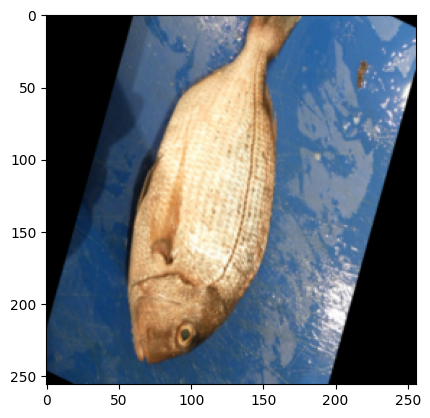

In [37]:
def evaluate_accuracy(test_loader, test_data, model):
    correct = 0
    total = 0

    dataloader = test_loader
    with torch.no_grad():
            for data in dataloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the', len(test_data), 'test images: ', 100 * correct // total, '%')

evaluate_accuracy(test_loader, val_data, model)

show_image(val_data, 0)
            

The image truly belongs to class:  4 Red Sea Bream
tensor([2, 7, 8, 6, 8, 3, 4, 0, 4, 7, 5, 6, 4, 1, 6, 6, 1, 1, 7, 8, 5, 8, 5, 3,
        7, 6, 1, 4, 0, 7, 4, 6])
tensor([2, 7, 8, 6, 8, 3, 4, 0, 4, 7, 5, 6, 4, 1, 6, 6, 1, 1, 7, 8, 5, 8, 5, 3,
        7, 6, 1, 4, 0, 7, 4, 6])
The image was predicted to belong to class:  4 Red Sea Bream


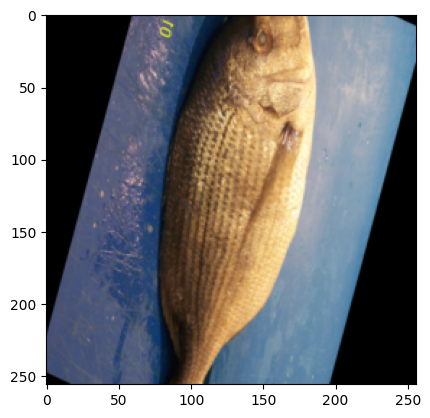

In [39]:
#show_image(test_data, 0)
#image, label = test_data[0]

def test_single_image(test_loader, model, idx):
    with torch.no_grad():
        data1 = next(iter(test_loader))  # get the first data item from the dataloader
        data2 = next(iter(test_loader)) #theese batches produces same output, check it out!!!!! Det har noe med shuffle å gjøre!

        images, labels = data1

        #Get a image for testing, choosing the first one
        first_image = images[idx]
        first_label = labels[idx]

        #Show first image
        plt.imshow(first_image.permute(1,2,0), cmap='gray')

        #Printing the real class
        print("The image truly belongs to class: ", first_label.item(), classes[first_label.item()])

        #Get predictions as a list for all the images in the dataloader
        outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    #Print the predicted classes for the batch we predicted
    print(predicted)
    print(labels)

    #Print the predicted class for the image we showed
    print("The image was predicted to belong to class: ", predicted[idx].item(), classes[predicted[idx].item()])
    
test_single_image(val_loader, model, 6)


In [57]:
def classes_hit(test_loader, model, num_classes): ####MÅÅÅÅÅÅ sjekke denne når jeg er tilbake
    predicted = []
    labels = []
    with torch.no_grad():
        for X, y in test_loader:
            predict = model(X)
            _, pre = torch.max(predict.data, 1)
            predicted.append(pre)
            labels.append(y)

        #Get predictions as a list for all the images in the dataloader
        #outputs = model(images)

        #_, predicted = torch.max(outputs.data, 1)

    #Print the predicted classes for the batch we predicted
    print("Predictd classes")
    print(predicted)
    print("Coreect labels: ")
    print(labels)
    print("________________________________")

    keys = range(0, num_classes)
    correct = {key: None for key in keys}
    miss = {key: None for key in keys}
    for k in correct:
        correct[k] = 0
        miss[k] = 0
    

    for i in range(len(predicted)):
        if predicted[i] == labels[i]:
            correct[predicted[i].item()] += 1
        else:
            miss[predicted[i].item()] += 1
    
    #Print it pretty
    for c in range(num_classes):
        print(classes[c], "got", correct[c], "correct predictions")


    print("_________________________________")
    for c in range(num_classes):
        print(classes[c], "got", miss[c], "predictions that was mistaken")

print(len(test_data)) #disse størrelsene funker ikke.... Hva er galt her?
classes_hit(test_loader, model, num_classes)

1200
Predictd classes
[tensor([6, 5, 6, 3, 7, 7, 3, 3, 3, 7, 1, 5, 2, 4, 8, 0, 0, 4, 3, 1, 8, 1, 0, 4,
        8, 1, 0, 7, 2, 2, 6, 2]), tensor([5, 4, 0, 7, 4, 0, 7, 5, 2, 7, 2, 7, 4, 8, 6, 5, 7, 4, 1, 8, 7, 3, 3, 2,
        1, 0, 0, 0, 8, 5, 0, 1]), tensor([6, 7, 2, 1, 0, 7, 7, 4, 4, 2, 1, 1, 3, 6, 2, 6, 1, 3, 3, 1, 2, 4, 7, 7,
        5, 7, 3, 3, 6, 2, 5, 5]), tensor([1, 0, 0, 7, 6, 1, 2, 2, 1, 0, 1, 4, 4, 7, 3, 0, 6, 6, 2, 4, 5, 6, 4, 7,
        7, 5, 2, 2, 3, 1, 5, 8]), tensor([6, 5, 0, 4, 7, 0, 7, 0, 1, 4, 7, 7, 8, 4, 5, 8, 7, 2, 0, 3, 3, 4, 3, 8,
        6, 8, 5, 7, 4, 0, 6, 5]), tensor([3, 5, 2, 4, 1, 7, 0, 1, 6, 0, 4, 4, 8, 6, 0, 2, 8, 3, 2, 2, 1, 3, 6, 8,
        3, 4, 1, 1, 6, 1, 1, 4]), tensor([1, 4, 3, 3, 4, 8, 8, 0, 5, 2, 0, 2, 6, 2, 3, 1, 1, 5, 8, 4, 2, 3, 7, 7,
        7, 1, 0, 6, 0, 3, 0, 6]), tensor([3, 3, 6, 5, 3, 3, 5, 3, 0, 2, 6, 5, 6, 1, 0, 8, 1, 4, 2, 8, 3, 6, 4, 5,
        3, 0, 3, 8, 4, 6, 6, 8]), tensor([4, 1, 6, 6, 6, 2, 0, 6, 4, 0, 5, 2, 2, 7, 5, 1, 5, 8, 7, 

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

# Plot loss and accuracy

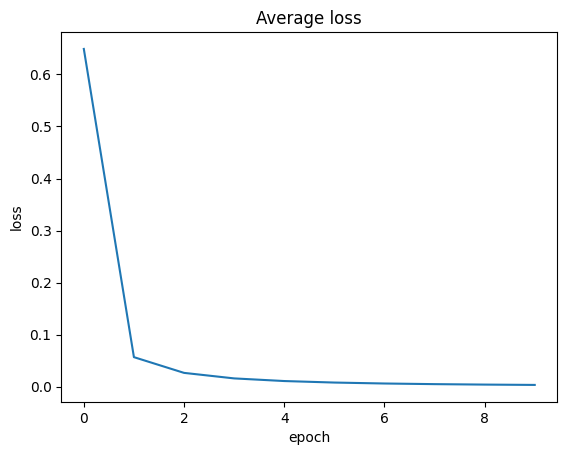

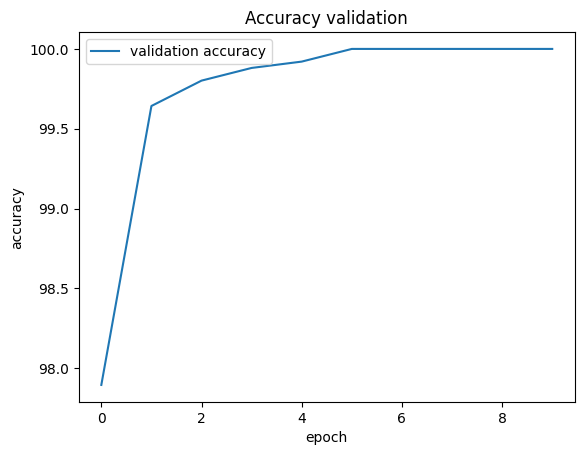

In [16]:
def plot_loss(epochs, loss_vals):
    plt.figure(1)
    plt.plot(list(range(0, epochs, 1)), loss_vals)
    plt.title('Average loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')

def plot_accuracy(epochs, vaccuracy_vals):
    plt.figure(2)
    plt.plot(list(range(0, epochs, 1)), vaccuracy_vals, label="validation accuracy")
    plt.legend(loc="upper left")
    plt.title('Accuracy validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()


plot_loss(epochs, loss_vals)
plot_accuracy(epochs, validation_accuracy_vals) #validation accuracy and test accuracy are the same


# Trying to get TensorBoard to work trough a new method of training: https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html

In [ ]:


print(len(val_loader))
print(len(val_data))

for epo in range(1):
    running_loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            model.train(False)

            for j, vdata in enumerate(val_loader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs) 
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            model.train(True)

            avg_loss = running_loss/1000
            avg_vloss = running_vloss/1000

            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epo * len(train_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()


        

79
540
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

writer.add_graph(model, images)
writer.flush()

1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
1---------------
torch.Size([32, 3, 32, 32])
2---------------
torch.Size([32, 6, 15, 15])
3---------------
torch.Size([32, 16, 6, 6])
4---------------
torch.Size([32, 576])
5---------------
torch.Size([32, 32])
6---------------
torch.Size([32, 32])
